# Import and optimization

In [154]:
!pip install missingno phik boule osfclient cartopy pygeodesy

In [155]:
# !osf -p  8zvwm clone

In [156]:
# import urllib.request
# url = 'https://sourceforge.net/projects/geographiclib/files/geoids-distrib/egm2008-1.tar.bz2'
# filename = 'Data/egm2008-1.tar.bz2'
# urllib.request.urlretrieve(url, filename)

In [157]:
# ! tar  -xvf  Data/egm2008-1.tar.bz2

In [158]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import missingno
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import phik
from pygeodesy import GeoidKarney, LatLon_

from sklearn.model_selection import train_test_split


In [159]:
import warnings
warnings.filterwarnings("ignore")

In [238]:
class CFG:
    TARGET = 'potential'
    N_FOLDS = 5
    RANDOM_STATE = 3

    COLORADO_PATH = './Data/Colorado_gravity_data.dat'
    GRAVD_PATH = './Data/GRAVD_ms05_median_debiased_1hz.txt'

In [161]:
class DataLoader:
    def __init__(self, colorado: pd.DataFrame, gravd: pd.DataFrame):
        self.colorado = colorado
        self.gravd = gravd
        self.log_features = []  # Список признаков для трансформации
        self.X = None
        self.y = None
    

    @staticmethod
    def reduce_mem_usage(dataframe):
        """ 
        Уменьшает использование памяти dataframe путем преобразования типов данных
        с автоматическим пропуском временных столбцов
        """
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            
            # Пропускаем временные столбцы и категориальные данные
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue
                
            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        dataframe[col] = dataframe[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        dataframe[col] = dataframe[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                # Оптимизация строковых столбцов
                dataframe[col] = dataframe[col].astype('category')
        
        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB")
        print(f"Экономия {(start_mem - end_mem) / start_mem * 100:.1f}%")
        
        return dataframe


    def load(self, option='compare'):
        print(f'Loading data')
        print(f'Choosed option:{option}')

        if option == 'compare':
            self.colorado = self.colorado.merge(self.gravd, left_on='latitude(deg)', right_on='lat(deg)', how='outer')
        elif option == 'ground':
            pass

        self.colorado = self.reduce_mem_usage(self.colorado)

In [162]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        # hex_colors = [matplotlib.colors.to_hex(color) for color in colors]
        # print(hex_colors)
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        #inner_colors = ['#59b3a3',] #'#433C64']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    
    @staticmethod
    def blinks(data: pd.DataFrame) -> None:
        print('Data gaps')
        missingno.matrix(data)

In [163]:
loader = DataLoader(
    colorado=pd.read_csv(CFG.COLORADO_PATH, 
                      names=['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)', 'survey ID', 'year'],
                        skipinitialspace=True,
                        sep=' '),
    gravd=pd.read_csv(CFG.GRAVD_PATH,
                        skipinitialspace=True),
)

In [164]:
loader.load(option='ground')

Loading data
Choosed option:ground
Изначальное использование памяти: 2.71 MB
Итоговое использование памяти: 0.79 MB
Экономия 70.8%


In [165]:
loader.colorado.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       37.06250         253.000                           2222.0   
1       37.06250         253.000                           2128.0   
2       37.03125         253.125                           2262.0   
3       37.03125         252.625                           1854.0   
4       37.03125         252.750                           1897.0   

   gravity(mGal)  survey ID  year  
0    979220.3125        746  9999  
1    979239.4375        746  9999  
2    979223.8750        746  9999  
3    979277.0625        746  9999  
4    979277.0625       5908  9999

In [166]:
loader.colorado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59303 entries, 0 to 59302
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   latitude(deg)                    59303 non-null  float16
 1   longitude(deg)                   59303 non-null  float16
 2   orthometric height above MSL(m)  59303 non-null  float16
 3   gravity(mGal)                    59303 non-null  float32
 4   survey ID                        59303 non-null  int16  
 5   year                             59303 non-null  int16  
dtypes: float16(3), float32(1), int16(2)
memory usage: 810.9 KB


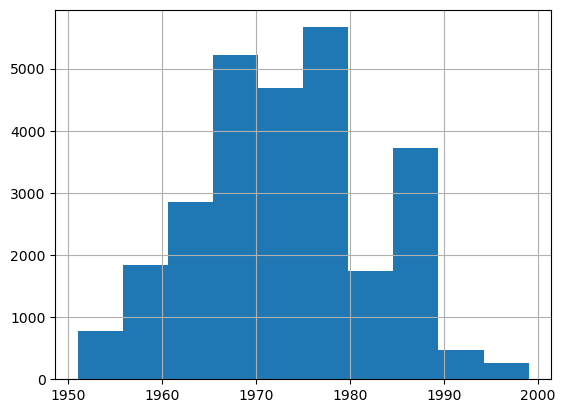

In [167]:
loader.colorado.query('year < 9999 and year > 1950')['year'].hist();

In [168]:
loader.colorado = loader.colorado.loc[(loader.colorado['year'] < 9999) & (loader.colorado['year'] > 1950)]

In [169]:
# for data in [loader.colorado]:
#     DataAnalysis.info_df(data)
#     DataAnalysis.blinks(data)
#     DataAnalysis.view_distribution(data, numeric_col=True)
#     DataAnalysis.correlations(data)

In [170]:
DataAnalysis.summary(loader.colorado).style.background_gradient(cmap='Blues')

In [171]:
loader.colorado.describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

In [172]:
loader.colorado.drop_duplicates(inplace=True)
loader.colorado.reset_index(drop=True, inplace=True)

# Features

In [173]:
FEATURES = ['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)']
df = loader.colorado[FEATURES]
df.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       36.50000         250.500                           1631.0   
1       36.46875         250.625                           1747.0   
2       36.43750         250.750                           2144.0   
3       36.40625         250.750                           1904.0   
4       36.34375         250.750                           2084.0   

   gravity(mGal)  
0    979346.0000  
1    979328.1250  
2    979252.8750  
3    979303.6875  
4    979268.5000

In [174]:
geoidinterpolator=GeoidKarney('geoids/egm2008-1.pgm')

In [175]:
class Gravity:
    def __init__(self):
        pass


    @staticmethod
    def height_anomaly(B: float, L: float) -> float:
        ll = LatLon_(latlonh=B, lon=L, wrap=True) # преобразование в формат библиотеки pygeodesy
        h_anomaly = geoidinterpolator(ll)
        return h_anomaly
    
    
    @staticmethod
    def gamma_mean(B: float, L: float, H: float) -> float:
        # программа составлена по нормальным формулам для расчета силы тяжести, Огородова Л. В. "Высшая геодезия", 2006, стр 85, формула 3.65 и 3.74
        # параметры нормальной земли взяты из приказа "Об утверждении геометрических и физических числовых геодезических параметров
        # государственной геодезической системы координат 2011 года"
        gamma_e=978032.696
        beta=0.00530243
        beta1=0.00000585
        norm_gravity_gradient=0.3086
        gamma_mean=gamma_e*(1-beta*np.sin(np.radians(B))**2-beta1*np.sin(2*np.radians(B))**2)-(H/2)*norm_gravity_gradient
        return gamma_mean
    
    def potential(g_mean: float, h_geodesy: float, B: float) -> float:

        GM = 3986005E8
        a = 6378137
        b = 6356752.3141
        w = 7292115E-11
        E = math.sqrt(a**2 + b**2)

        q = .5*((1+3*((h_geodesy**2)/E**2))*math.atan(E / h_geodesy) - 3* (h_geodesy/E))
        q0 = .5*((1+3*((h_geodesy**2)/E**2))*math.atan(E / b) - 3* (b/E)) 

        u_ellipsoid = ((GM) / E) * math.atan(E / h_geodesy) + .5*(w**2)*(a**2)*(q/q0)*((math.sin(B)**2) - 1/3) + .5*(w**2)*(h_geodesy**2 + E**2) * math.cos(B)**2

        return -(g_mean) * h_geodesy + u_ellipsoid

In [176]:
df['H_anomaly'] = np.vectorize(Gravity.height_anomaly)(df['latitude(deg)'], df['longitude(deg)'])

In [177]:
df['H_geodesy'] = df['orthometric height above MSL(m)'] + df['H_anomaly']

In [178]:
df['gamma_mean'] = np.vectorize(Gravity.gamma_mean)(df['latitude(deg)'], df['longitude(deg)'],df['H_geodesy'])

In [179]:
df['potential'] = np.vectorize(Gravity.potential)(df['gravity(mGal)'], df['H_geodesy'],np.radians(df['latitude(deg)']))

In [183]:
df.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       36.50000         250.500                           1631.0   
1       36.46875         250.625                           1747.0   
2       36.43750         250.750                           2144.0   
3       36.40625         250.750                           1904.0   
4       36.34375         250.750                           2084.0   

   gravity(mGal)  H_anomaly    H_geodesy     gamma_mean     potential  
0    979346.0000 -20.664225  1610.335775  975944.126332 -1.507417e+09  
1    979328.1250 -20.269422  1726.730578  975928.874563 -1.621377e+09  
2    979252.8750 -19.840444  2124.159556  975870.258327 -2.010432e+09  
3    979303.6875 -19.763147  1884.236853  975909.984558 -1.775582e+09  
4    979268.5000 -19.668797  2064.331203  975887.605611 -1.951877e+09

# Data sets

In [149]:
# X_train, X_test, y_train, y_test = train_test_split(
#     # df.drop(columns=CFG.TARGET), 
#     df[['latitude(deg)', 'longitude(deg)', 'H_geodesy']],
#     df[CFG.TARGET], 
#     test_size=0.33, 
#     random_state=CFG.RANDOM_STATE
# )

In [239]:
import torch
import pandas as pd
import numpy as np

class PotentialModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2))
    
    def forward(self, x):
        return self.fc(x)

def compute_laplacian(model, coords):
    """
    Вычисление Лапласиана с проверкой градиентов
    """
    try:
        # Создаем новые тензоры с градиентами
        x = coords[:, 0].detach().requires_grad_(True)
        y = coords[:, 1].detach().requires_grad_(True)
        z = coords[:, 2].detach().requires_grad_(True)
        
        new_coords = torch.stack([x, y, z], dim=1)
        
        # Проверка наличия градиента
        if not x.requires_grad or not y.requires_grad or not z.requires_grad:
            raise RuntimeError("Координаты не требуют градиента")
            
        W = model(new_coords)
        
        # Первые производные с проверкой
        if W.requires_grad:
            grad_outputs = torch.ones_like(W)
            dW_dx = torch.autograd.grad(W.sum(), x, create_graph=True, allow_unused=True)[0]
            dW_dy = torch.autograd.grad(W.sum(), y, create_graph=True, allow_unused=True)[0]
            dW_dz = torch.autograd.grad(W.sum(), z, create_graph=True, allow_unused=True)[0]
            
            # Проверка на None (неиспользованные градиенты)
            if dW_dx is None or dW_dy is None or dW_dz is None:
                return torch.zeros_like(x)
                
            # Вторые производные
            d2W_dx2 = torch.autograd.grad(dW_dx.sum(), x, retain_graph=True, allow_unused=True)[0]
            d2W_dy2 = torch.autograd.grad(dW_dy.sum(), y, retain_graph=True, allow_unused=True)[0]
            d2W_dz2 = torch.autograd.grad(dW_dz.sum(), z, allow_unused=True)[0]
            
            # Замена None на нули
            # d2W_dx2 = torch.zeros_like(x) if d2W_dx2 is None else d2W_dx2
            # d2W_dy2 = torch.zeros_like(y) if d2W_dy2 is None else d2W_dy2
            # d2W_dz2 = torch.zeros_like(z) if d2W_dz2 is None else d2W_dz2
            
            return d2W_dx2 + d2W_dy2 + d2W_dz2
        else:
            return torch.zeros_like(x)
    except Exception as e:
        print(f"Ошибка при вычислении лапласиана: {str(e)}")
        return torch.zeros_like(coords[:, 0])

# Загрузка данных
X = torch.tensor(df[['latitude(deg)', 'longitude(deg)', 'H_geodesy']].values, 
                dtype=torch.float32)
y_true = torch.tensor(df[CFG.TARGET].values, dtype=torch.float32).view(-1, 1)

# Разделение данных
train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_true[:train_size], y_true[train_size:]

# Инициализация модели
model = PotentialModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Обучение с обработкой ошибок
batch_size = 256
epochs = 5000

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    
    for i in range(0, X_train.size()[0], batch_size):
        try:
            indices = permutation[i:i+batch_size]
            batch_X = X_train[indices]
            batch_y = y_train[indices]
            
            optimizer.zero_grad()
            
            # Основной прямой проход
            W_pred = model(batch_X)
            loss_mse = criterion(W_pred, batch_y)
            
            # Условие Лапласа с обработкой ошибок
            laplacian = compute_laplacian(model, batch_X)
            loss_laplace = torch.mean(laplacian**2)
            
            # Общий лосс
            loss = loss_mse + 0.1 * loss_laplace
            
            # Проверка на NaN перед backward
            if not torch.isnan(loss).any():
                loss.backward()
                optimizer.step()
            else:
                print("Обнаружен NaN в функции потерь, пропускаем батч")
                
        except Exception as e:
            print(f"Ошибка в батче {i//batch_size}: {str(e)}")
            continue
    
    # Валидация
    model.eval()
    with torch.no_grad():
        try:
            test_pred = model(X_test)
            test_mse = criterion(test_pred, y_test)
            test_laplace = torch.mean(compute_laplacian(model, X_test)**2)
            
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | '
                  f'Test MSE: {test_mse.item():.4f} | Test Laplace: {test_laplace.item():.4f}')
        except Exception as e:
            print(f"Ошибка при валидации: {str(e)}")

# Финальная проверка
model.eval()
with torch.no_grad():
    try:
        # sample_indices = torch.randint(0, len(X_test), (5,))
        # test_samples = X_test[sample_indices]
        predictions = model(X_test)
        laplacians = compute_laplacian(model, X_test)
        
        print("\nФинальные примеры:")
        for i in range(5):
            print(f"Точка {i+1}:")
            print(f"Координаты: {X_test[i].numpy()}")
            print(f"W: {predictions[i].item():.4f}")
            print(f"ΔW: {laplacians[i].item():.6f}")
    except Exception as e:
        print(f"Ошибка при финальной проверке: {str(e)}")

Epoch 1/5000 | Train Loss: 5100856542601674752.0000 | Test MSE: 5669712522731585536.0000 | Test Laplace: 0.0000
Epoch 2/5000 | Train Loss: 5195553630811324416.0000 | Test MSE: 5669694930545541120.0000 | Test Laplace: 0.0000
Epoch 3/5000 | Train Loss: 4756394942782242816.0000 | Test MSE: 5669664144219963392.0000 | Test Laplace: 0.0000
Epoch 4/5000 | Train Loss: 5209175480367841280.0000 | Test MSE: 5669621813022294016.0000 | Test Laplace: 0.0000
Epoch 5/5000 | Train Loss: 4831912699912781824.0000 | Test MSE: 5669566837440905216.0000 | Test Laplace: 0.0000
Epoch 6/5000 | Train Loss: 4745842379934662656.0000 | Test MSE: 5669500866743238656.0000 | Test Laplace: 0.0000
Epoch 7/5000 | Train Loss: 5349937707734794240.0000 | Test MSE: 5669423351173480448.0000 | Test Laplace: 0.0000
Epoch 8/5000 | Train Loss: 5041486762992467968.0000 | Test MSE: 5669334290731630592.0000 | Test Laplace: 0.0000
Epoch 9/5000 | Train Loss: 5249911836421128192.0000 | Test MSE: 5669234784929316864.0000 | Test Laplace:

In [240]:
from plotly.offline import init_notebook_mode, plot
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

longitudes = X_test[:, 0].flatten()  # Преобразуем в 1D массив
latitudes = X_test[:, 1].flatten()   # Преобразуем в 1D массив
heights = predictions.flatten()      # Преобразуем в 1D массив

# Преобразуем данные в numpy массивы, если они не являются таковыми
if not isinstance(longitudes, np.ndarray):
    longitudes = np.array(longitudes)
if not isinstance(latitudes, np.ndarray):
    latitudes = np.array(latitudes)
if not isinstance(heights, np.ndarray):
    heights = np.array(heights)

# Убедимся, что массивы одномерные
longitudes = longitudes.ravel()
latitudes = latitudes.ravel()
heights = heights.ravel()

# Удалим NaN значения
mask = ~np.isnan(longitudes) & ~np.isnan(latitudes) & ~np.isnan(heights)
longitudes = longitudes[mask]
latitudes = latitudes[mask]
heights = heights[mask]

# Проверим, что данные остались
if len(longitudes) == 0:
    raise ValueError("После удаления NaN не осталось данных для построения графика")

# Создаем сетку для интерполяции
grid_x, grid_y = np.mgrid[
    np.min(longitudes):np.max(longitudes):100j,
    np.min(latitudes):np.max(latitudes):100j
]

# Интерполяция
try:
    grid_z = griddata(
        (longitudes, latitudes), 
        heights, 
        (grid_x, grid_y), 
        method='cubic',
        fill_value=np.nanmean(heights)
    )
except:
    grid_z = griddata(
        (longitudes, latitudes), 
        heights, 
        (grid_x, grid_y), 
        method='linear',
        fill_value=np.nanmean(heights)
    )
init_notebook_mode(connected=True)
# Создаем 3D поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, 
    y=grid_y, 
    z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    surfacecolor=grid_z
)])

# Настройки макета
fig.update_layout(
    title='3D поверхность предсказанных значений',
    scene=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Потенциал'
    )
)

fig.write_html("plot.html")
fig.show()

ValueError: operands could not be broadcast together with shapes (5415,) (10830,) 

In [232]:
from plotly.offline import init_notebook_mode, plot
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

longitudes = X_test[:, 0].flatten()  # Преобразуем в 1D массив
latitudes = X_test[:, 1].flatten()   # Преобразуем в 1D массив
heights = y_test     # Преобразуем в 1D массив

# Преобразуем данные в numpy массивы, если они не являются таковыми
if not isinstance(longitudes, np.ndarray):
    longitudes = np.array(longitudes)
if not isinstance(latitudes, np.ndarray):
    latitudes = np.array(latitudes)
if not isinstance(heights, np.ndarray):
    heights = np.array(heights)

# Убедимся, что массивы одномерные
longitudes = longitudes.ravel()
latitudes = latitudes.ravel()
heights = heights.ravel()

# Удалим NaN значения
mask = ~np.isnan(longitudes) & ~np.isnan(latitudes) & ~np.isnan(heights)
longitudes = longitudes[mask]
latitudes = latitudes[mask]
heights = heights[mask]

# Проверим, что данные остались
if len(longitudes) == 0:
    raise ValueError("После удаления NaN не осталось данных для построения графика")

# Создаем сетку для интерполяции
grid_x, grid_y = np.mgrid[
    np.min(longitudes):np.max(longitudes):100j,
    np.min(latitudes):np.max(latitudes):100j
]

# Интерполяция
try:
    grid_z = griddata(
        (longitudes, latitudes), 
        heights, 
        (grid_x, grid_y), 
        method='cubic',
        fill_value=np.nanmean(heights)
    )
except:
    grid_z = griddata(
        (longitudes, latitudes), 
        heights, 
        (grid_x, grid_y), 
        method='linear',
        fill_value=np.nanmean(heights)
    )
init_notebook_mode(connected=True)
# Создаем 3D поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, 
    y=grid_y, 
    z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    surfacecolor=grid_z
)])

# Настройки макета
fig.update_layout(
    title='3D поверхность предсказанных значений',
    scene=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Потенциал'
    )
)

fig.write_html("plot_test.html")
fig.show()

In [234]:
pd.DataFrame(y_test - predictions).describe()

0
count  5.415000e+03
mean   7.350274e+05
std    6.662015e+07
min   -2.273976e+08
25%   -3.015053e+07
50%    1.337600e+07
75%    2.453984e+07
max    1.874924e+08

# DeepXDE

In [ ]:
# !pip install DeepXDE
# !pip install --upgrade tensorflow
# !pip install protobuf==3.20.3

In [ ]:
import deepxde as dde
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features and target
X = X_train.values
y = y_train.values.reshape(-1, 1)

# 2. Data preprocessing
# Scale features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

# Split into train and test sets
X_t, X_te, y_t, y_te = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 3. Define the neural network architecture
input_dim = X.shape[1]
output_dim = 1

net = dde.nn.FNN(
    [input_dim] + [64] * 4 + [output_dim],  # 4 hidden layers with 64 neurons each
    "tanh",  # Activation function
    "Glorot normal"  # Weight initialization
)

# 4. Define the data and model
data = dde.data.DataSet(
    X_train=X_t,
    y_train=y_t,
    X_test=X_te,
    y_test=y_te,
)

model = dde.Model(data, net)

# 5. Compile and train the model
model.compile(
    "adam",  # Optimizer
    lr=0.001,  # Learning rate
    metrics=["mean l2 relative error"],  # Evaluation metric
    loss="mean squared error"  # Loss function
)

losshistory, train_state = model.train(
    iterations=1000,  # Number of training iterations
    batch_size=32,  # Batch size
    display_every=100  # Display progress every 1000 iterations
)

# 6. Evaluate the model
# print("Training metrics:", train_state.metrics_train)
# print("Test metrics:", train_state.metrics_test)

# 7. Make predictions (example)
sample_input = X_test.values
scaled_input = x_scaler.transform(sample_input)
scaled_pred = model.predict(scaled_input)
prediction = y_scaler.inverse_transform(scaled_pred)
print("Predicted potential:", prediction)

In [ ]:
class GravityPotential3DPipeline:
    def __init__(self, config, points):
        self.config = config
        self.points = points
        self.study = None
        self.best_model = None
        self.best_params = None
        self.results_dir = "results"
        if not os.path.exists(self.results_dir):
            os.mkdir(self.results_dir)

        self.a = 6378137.0
        self.GM = 3986005E8
        self.scale_factor = 1.0

    def prepare_data(self):
        # self.obs_points = np.column_stack([
        #     (self.a + self.points['H_geodesy']) * np.cos(np.deg2rad(self.points['latitude(deg)'])) * np.cos(np.deg2rad(self.points['longitude(deg)'])),
        #     (self.a + self.points['H_geodesy']) * np.cos(np.deg2rad(self.points['latitude(deg)'])) * np.sin(np.deg2rad(self.points['longitude(deg)'])),
        #     (self.a + self.points['H_geodesy']) * np.sin(np.deg2rad(self.points['latitude(deg)'])) / self.scale_factor,
        # ])
        self.obs_values = self.points[CFG.TARGET].values.reshape(-1, 1)
        self.gravity_points = self.obs_points
        self.gravity_values = self.points['gravity(mGal)'].values.reshape(-1, 1)

        obs_points_scaler = StandardScaler()
        obs_values_scaler = StandardScaler()

        gravity_points_scaler = StandardScaler()
        gravity_values_scaler = StandardScaler()

        self.obs_points_scaled = obs_points_scaler.fit_transform(self.obs_points)
        self.obs_values_scaled = obs_values_scaler.fit_transform(self.obs_values)

        self.gravity_points_scaled = gravity_points_scaler.fit_transform(self.gravity_points)
        self.gravity_values_scaled = gravity_values_scaler.fit_transform(self.gravity_values)

        self.train_points, self.test_points, self.train_values, self.test_values = \
        train_test_split(
            self.obs_points_scaled, self.obs_values_scaled, test_size=.2, random_state=CFG.RANDOM_STATE
        )
        print(f"Obs values contains None: {np.any(np.isnan(self.obs_values))}")
        print(f"Train values contains None: {np.any(np.isnan(self.train_values))}")

    def build_pde_system(self, params=None):
        if params is None:
            params = self.config['default_params']

        
        geom = dde.geometry.Cuboid(
            [self.config['x_min'], self.config['y_min'], self.config['z_min']],
            [self.config['x_max'], self.config['y_max'], self.config['z_max']]
        )

        def pde(x, y):
            dy_xx = dde.grad.hessian(y, x, i=0, j=0)
            dy_yy = dde.grad.hessian(y, x, i=1, j=1)
            dy_zz = dde.grad.hessian(y, x, i=2, j=2)
            return dy_xx + dy_yy + dy_zz
        
        def boundary_obs(x, on_boundary):
            return np.any(np.all(np.isclose(x, self.train_points), axis=1), axis=0)

        def boundary_gravity(x, on_boundary):
            r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2) * self.scale_factor
            return on_boundary and np.isclose(r, self.a, rtol=1e-3)
        

        bc_obs = dde.icbc.PointSetBC(self.train_points, self.train_values, component=0)
        bc_gravity = dde.icbc.NeumannBC(
            geom,
            lambda x: -self.gravity_values_scaled,
            boundary_gravity
        )

        data = dde.data.PDE(
            geom,
            pde,
            [bc_obs, bc_gravity],
            num_domain=params.get('num_domain', 500),
            num_boundary=params.get('num_boundary', 100),
            num_test=200,
        )
        print(f"Train points shape: {self.train_points.shape}")
        print(f"Train values shape: {self.train_values.shape}")
        print(f"Sample train value: {self.train_values[0]}") 
        return data
    
    def build_model(self, data, params):
        net = dde.nn.FNN(
            [3] + [params['num_neurons']] * params['num_layers'] + [1],
            params['activation'],
            "Glorot normal",
        )

        def l2_relative_error(y_true, y_pred):
            y_true = np.array(y_true, dtype=np.float32)
            y_pred = np.array(y_pred, dtype=np.float32)
            if np.any(np.isnan(y_true)) or np.any(np.isnan(y_pred)):
                return float('inf')
            return np.linalg.norm(y_true - y_pred) / np.linalg.norm(y_true)

        model = dde.Model(data, net)
        model.compile(
            "adam",
            lr=params['lr'],
            # metrics=["l2 relative error"],
            metrics=[l2_relative_error],
            loss_weights=[1,1,1]
        )
        return model
    
    def objective(self, trial):
        params = {
            'num_layers': trial.suggest_int('num_layers', 2, 5),
            'num_neurons': trial.suggest_int('num_neurons', 30, 150, step=20),
            'activation': trial.suggest_categorical('activation', ['tanh', 'relu', 'swish']),
            'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
            'num_domain': trial.suggest_int('num_domain', 300, 1000, step=100),
            'num_boundary': trial.suggest_int('num_boundary', 50, 200, step=50),
            'batch_size': trial.suggest_categorical('batch_size', [32,64,128]),
        }

        data = self.build_pde_system(params=params)
        model = self.build_model(data, params)

        early_stopping = dde.callbacks.EarlyStopping(
            min_delta=1e-5,
            patience=1000,
            monitor='loss_train'
        )

        losshistory, _ = model.train(
            iterations=3000,
            display_every=1000,
            batch_size=params['batch_size'],
            callbacks=[early_stopping]
        )

        return np.min(losshistory.loss_train)
    
    def optimize_hyperparametrs(self):
        sampler = optuna.samplers.TPESampler(seed=CFG.RANDOM_STATE)
        self.study = optuna.create_study(
            direction='minimize',
            sampler=sampler,
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
        )

        self.study.optimize(
            self.objective,
            n_trials=self.config['optuna']['n_trials'],
            timeout=self.config['optuna']['timeout']
        )

        self.best_params = self.study.best_params
        self.best_params['loss'] = self.study.best_value

        trials_df = self.study.trials_dataframe()
        trials_df.to_csv(f"{self.results_dir}/optuna_results.csv", index=False)

        fig = optuna.visualization.plot_optimization_history(self.study)
        fig.write_image(f"{self.results_dir}/optimization_history.png")

        return self.best_params
    
    def train_final_model(self):
        if self.best_params is None:
            self.best_params = self.config['default_params']

        data = self.build_pde_system(self.best_params)
        self.best_model = self.build_model(data, self.best_params)

        checkpointer = dde.callbacks.ModelCheckpoint(
            f"{self.results_dir}/model.ckpt",
            save_better_only=True,
            period=1000
        )

        self.losshistory, self.train_state = self.best_model.train(
            iterations=self.config['training']['max_iterations'],
            display_every=1000,
            batch_size=self.best_params.get('batch_size', 64),
            callbacks=[checkpointer]
        )

        self.best_model.save(f"{self.results_dir}/final_model")

        return self.losshistory, self.train_state
    
    def evaluate_model(self):
        if self.best_model is None:
            raise ValueError("Model not trained yet")
        
        test_pred = self.best_model.predict(self.test_points)
        test_error = np.mean(np.abs(test_pred.flatten() - self.test_values))

        gravity_pred = -self.best_model.predict(
            self.gravity_points_scaled,
            operator=lambda x, y: dde.grad.hessian(y, x, i=0, j=2)
        )
        gravity_error = np.mean(np.abs(gravity_pred.flatten() - self.gravity_values))

        metrics = {
            'potential_test_error': test_error,
            'gravity_test_error': gravity_error,
            'training_loss': np.min(self.losshistory.loss_train)
        }

        # with open(f"{self.results_dir}/metrics.json", 'w') as f:
        #     json.dump(metrics, f)

        return metrics
    
    def run_pipeline(self):
        print("\nStep 1/4: Preparing data...")
        self.prepare_data()

        if self.config['run_optimization']:
            print("\nStep 2/4: Optimizing hyperparameters...")
            self.optimize_hyperparametrs()
            print(f"Best parameters found: {self.best_params}")
        else:
            self.best_params = self.config['default_params']

        print("\nStep 3/4: Training final model")
        self.train_final_model()

        print("\nStep 4/4: Evaluating model")
        metrics = self.evaluate_model()
        print(f"Evaluation metrics: {metrics}")

        # print("\nStep 5/5: Generating visualization")
        print("\nPipeline completed successfully!")
        return self.best_model, metrics

In [ ]:
config = {
    'x_min': -1.2,
    'x_max': 1.2,
    'y_min': -1.2,
    'y_max': 1.2,
    'z_min': -1.2,
    'z_max': 1.2,
    'optuna': {
        'n_trials': 5,
        'timeout': 7200
    },
    'training': {
        'max_iterations': 10000
    },
    'run_optimization': True
}

In [ ]:
pipeline = GravityPotential3DPipeline(config=config, points=df)
best_model, metrics = pipeline.run_pipeline()

# Baseline CatBoost

In [98]:
from catboost import *
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [99]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()

In [100]:
class LaplaceConditionObjective(object):
    def calc_ders_range(self, preds, targets, epsilon=1e-5):
        """
        preds — предсказанные значения W.
        targets — координаты (x, y, z) в виде массива (N, 3).
        epsilon — шаг для численных производных.
        """
        print(pd.DataFrame(targets))
        x, y, z = targets[:, 0], targets[:, 1], targets[:, 2]
        
        # Вторые производные (центральные разности)
        d2W_dx2 = (preds(x + epsilon, y, z) - 2 * preds(x, y, z) + preds(x - epsilon, y, z)) / (epsilon ** 2)
        d2W_dy2 = (preds(x, y + epsilon, z) - 2 * preds(x, y, z) + preds(x, y - epsilon, z)) / (epsilon ** 2)
        d2W_dz2 = (preds(x, y, z + epsilon) - 2 * preds(x, y, z) + preds(x, y, z - epsilon)) / (epsilon ** 2)
        
        laplacian = d2W_dx2 + d2W_dy2 + d2W_dz2
        grad = 2 * laplacian  # Производная MSE по laplacian
        hess = 2 * np.ones_like(laplacian)  # Вторая производная
        
        return list(zip(grad, hess))

In [101]:
def build_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'loss_function': LaplaceConditionObjective(),
        'eval_metric': 'RMSE',
        'task_type': 'CPU',
    }


    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(X_train, y_train, cat_features=cat_features),
        model.get_params(),
        early_stopping_rounds=100
    )
    return np.mean(cv_data['test-RMSE-mean'])

In [102]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=CFG.N_FOLDS)

[I 2025-07-10 14:29:02,706] A new study created in memory with name: no-name-42b6e0b2-3942-48df-b09d-e2d0b73d84c5
Got unsafe target value = -4.00695e+09 at object #0 of dataset learn
Got unsafe target value = -1.38712e+09 at object #0 of dataset test #0
[W 2025-07-10 14:29:02,777] Trial 0 failed with parameters: {'iterations': 456, 'learning_rate': 0.05921343138373912, 'depth': 8} because of the following error: CatBoostError('catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):\n  File "_catboost.pyx", line 1743, in _catboost._cpu_jit_method_wrap.new_method\n  File "c:\\ProgramData\\anaconda3\\envs\\DS\\lib\\site-packages\\numba\\core\\dispatcher.py", line 423, in _compile_for_args\n    error_rewrite(e, \'typing\')\n  File "c:\\ProgramData\\anaconda3\\envs\\DS\\lib\\site-packages\\numba\\core\\dispatcher.py", line 364, in error_rewrite\n    raise e.with_traceback(None)\nnumba.core.errors.TypingError: Failed in nopython mode pipeline (step: nopython front

Training on fold [0/3]
                0
0   -4.006947e+09
1   -2.504436e+09
2   -1.506151e+09
3   -2.499546e+09
4   -2.483723e+09
..            ...
995 -1.344648e+09
996 -2.036133e+09
997 -2.590057e+09
998 -1.982620e+09
999 -1.650114e+09

[1000 rows x 1 columns]
                0
0   -3.453910e+09
1   -2.654466e+09
2   -2.273270e+09
3   -2.216602e+09
4   -2.898576e+09
..            ...
995 -3.045126e+09
996 -2.278476e+09
997 -2.216575e+09
998 -2.420495e+09
999 -2.308692e+09

[1000 rows x 1 columns]
                0
0   -1.988008e+09
1   -2.027900e+09
2   -3.707337e+09
3   -2.715885e+09
4   -3.012253e+09
..            ...
995 -2.332556e+09
996 -2.565508e+09
997 -1.979947e+09
998 -3.476263e+09
999 -1.519417e+09

[1000 rows x 1 columns]
                0
0   -2.374144e+09
1   -1.070787e+09
2   -2.163867e+09
3   -1.717784e+09
4   -2.160222e+09
..            ...
995 -3.530757e+09
996 -2.210648e+09
997 -2.179142e+09
998 -1.698158e+09
999 -3.235317e+09

[1000 rows x 1 columns]
             

CatBoostError: catboost/python-package/catboost/helpers.cpp:57: Traceback (most recent call last):
  File "_catboost.pyx", line 1743, in _catboost._cpu_jit_method_wrap.new_method
  File "c:\ProgramData\anaconda3\envs\DS\lib\site-packages\numba\core\dispatcher.py", line 423, in _compile_for_args
    error_rewrite(e, 'typing')
  File "c:\ProgramData\anaconda3\envs\DS\lib\site-packages\numba\core\dispatcher.py", line 364, in error_rewrite
    raise e.with_traceback(None)
numba.core.errors.TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'DataFrame' of type Module(<module 'pandas' from 'c:\\ProgramData\\anaconda3\\envs\\DS\\lib\\site-packages\\pandas\\__init__.py'>)
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_6072\3639262002.py", line 8:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\DS\AppData\Local\Temp\ipykernel_6072\3639262002.py (8)[0m
[1m
File "..\..\..\AppData\Local\Temp\ipykernel_6072\3639262002.py", line 8:[0m
[1m<source missing, REPL/exec in use?>[0m


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "_catboost.pyx", line 1615, in _catboost._ObjectiveCalcDersRange
  File "_catboost.pyx", line 1748, in _catboost._cpu_jit_method_wrap.new_method
  File "C:\Users\DS\AppData\Local\Temp\ipykernel_6072\3639262002.py", line 9, in calc_ders_range
    x, y, z = targets[:, 0], targets[:, 1], targets[:, 2]
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed


In [ ]:
best_params = study.best_params
best_params

In [ ]:
rmses = []
preds = []

skf = KFold(n_splits=5, shuffle=True, random_state=CFG.RANDOM_STATE)

for CFG.N_FOLDS, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'### Fold {CFG.N_FOLDS+1} Training ###')
    X_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    X_v = X_train.iloc[valid_idx]
    y_v = y_train.iloc[valid_idx]

    X_train_pool = Pool(X_t, y_t, cat_features=cat_features)
    X_valid_pool = Pool(X_v, y_v, cat_features=cat_features)
    
    model = CatBoostRegressor(
        eval_metric='RMSE',
        learning_rate=best_params['learning_rate'],
        iterations=best_params['iterations'],
        depth=best_params['depth'],
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=50)

    preds.append(model.predict(X_valid_pool))

    rmse = root_mean_squared_error(y_v, model.predict(X_valid_pool))
    rmses.append(rmse)

    print(f'Fold {CFG.N_FOLDS+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.mean(rmses):.5f} +/- {np.std(rmses):.5f}')

In [226]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = df['longitude(deg)']
latitudes = df['latitude(deg)']
heights = df['potential']

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Potential',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
import plotly.graph_objects as go
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Potential',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = np.array(prediction)

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Potential',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = df['longitude(deg)']
latitudes = df['latitude(deg)']
heights = df['gravity(mGal)']

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = model.predict(X_test) - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
pd.DataFrame(model.predict(X_test) - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

# Baseline NN

In [ ]:
# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# 1. Выполним разделение и масштабирование
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=CFG.RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=CFG.RANDOM_STATE)

# 2. Масштабирование только числовых признаков
numeric_cols = X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

sc = MinMaxScaler()
X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = sc.transform(X_val[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])

In [ ]:
def build_neural_network(hp):    
    model = Sequential()
    # model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=3, max_value=12, step=2),
                activation=hp.Choice("activation", ["tanh", "relu", "linear"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [ ]:
build_neural_network(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_loss', 'min'),
    max_trials=2,
    executions_per_trial=3,
    overwrite=True,
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

In [ ]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [ ]:
callback = EarlyStopping(monitor='loss', patience=200)

In [ ]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

In [ ]:
predictions = best_NN.predict(X_test)

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = predictions.flatten() - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
pd.DataFrame(predictions.flatten() - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

In [ ]:
# Создание модели
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dense(1)  # Выходной слой без активации для регрессии
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Ранняя остановка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка модели
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.2f}, Test MAE: {test_mae:.2f}")

In [ ]:
predictions = model.predict(X_test)

In [ ]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = predictions.flatten() - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [ ]:
predictions.flatten()

In [ ]:
pd.DataFrame(predictions.flatten() - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')